# Assignment 08: 
# Text Mining and Regression using Dimensionality Reduction Methods [_/100 Marks]

### Follow These Instructions

Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.



#### In this assignment, we will study apply dimensionality reduction methods to improve our understanding of text data and to predict the sentiment of a set of texts. The dataset for this assignment comes from the Amazon website and represents 1,000 reviews which were labeled (by humans) as positive or negative. This application of data science is called [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) and it is widely used across many fields to get automated feedback when text opinions are expressed. You will also work with dimensionality reduction for classification and regression.
---

In [58]:
import numpy as np
import pandas as pd
#%pip install umap
from umap.umap_ import UMAP
from sklearn.decomposition import PCA, TruncatedSVD
import sklearn.feature_extraction.text as sktext
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from scipy.stats import t
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt
seed = 221113

---
## Task 1: Decomposition of the texts [ / 50 marks]

### Question 1.1 [ / 9 marks]

The dataset comes with the text and a binary variable which represents the sentiment, either positive or negative. Import the data and use sklearn's `TfidfVectorizer` to eliminate accents, special characters, and stopwords. In addition, make sure to eliminate words that appear in less than 5% of documents and those that appear in over 95%. You can also set `sublinear_tf` to `True`. After that, split the data into train and test with `test_size = 0.2` and `seed = seed`. Calculate the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) for both train and test. Note that you need to fit and transform the inputs for the train set but you only need to transform the inputs for the test set. Don't forget to turn the sparse matrices to dense ones after you apply the `Tf-Idf` transform.  

In [59]:
# Load the data [ /1 marks]
df = pd.read_csv('Reviews_sample.csv')

# Display the first 5 rows [ /1 marks]
df.head()

,text,label
0,Stuning even for the non-gamer: This sound tr...,1
1,The best soundtrack ever to anything.: I'm re...,1
2,Amazing!: This soundtrack is my favorite musi...,1
3,Excellent Soundtrack: I truly like this sound...,1
4,"Remember, Pull Your Jaw Off The Floor After H...",1


In [60]:
# Defining the TfidfVectorizer [ /2 marks]
tfidf = sktext.TfidfVectorizer(strip_accents='ascii', stop_words='english')

# Eliminate words that appear in <5% of documents and those that appear in >95%
tfidf.set_params(min_df=0.05, max_df=0.95)
tfidf.set_params(sublinear_tf=True)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=seed)

# Calculate the Tf-Idf transform [ /2 marks]
TfIDF_train = tfidf.fit_transform(X_train)
TfIDF_test = tfidf.transform(X_test)

# Turn sparse matrices into dense ones
TfIDF_train = TfIDF_train.toarray()
TfIDF_test = TfIDF_test.toarray()

From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required). Print the number of indices in the ouput using [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [61]:
# Print the number of indices [ /1 marks]
print(f'Training data has {TfIDF_train.shape[0]} samples and {len(tfidf.get_feature_names_out())} features')

Training data has 800 samples and 65 features


### Question 1.2 [ / 8 marks]
Now we have the TfIDF matrix so we can start working on the data. We hope to explore what some commonly occuring concepts are in the text reviews. We can do this using PCA. A PCA transform of the TF-IDF matrix will give us a basis of the text data, each component representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic. Calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts.

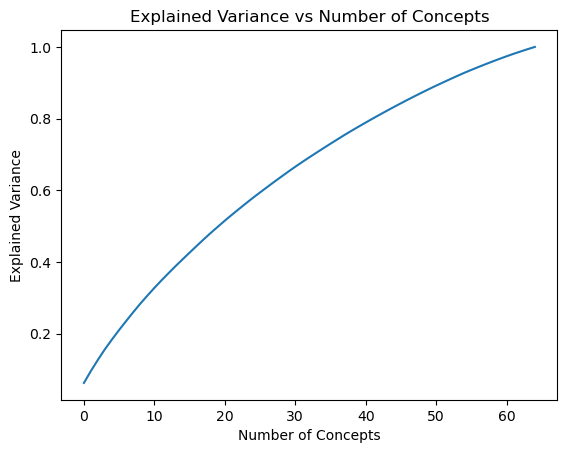

In [62]:
# Apply PCA on training data and get the explained variance [ / 3 marks]
pca = PCA(n_components=TfIDF_train.shape[1])
pca.fit(TfIDF_train)
explained_variance = pca.explained_variance_ratio_.cumsum()

# Plotting explained variance with number of concepts [ / 3 marks]
plt.plot(explained_variance)
plt.xlabel('Number of Concepts')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs Number of Concepts')
plt.show()

**Written Question:** Exactly how many concepts do we need to correctly explain at least 80% of the data? [ /2 marks]


In [63]:
# To get the exact index where the variance is above 80%
n_concepts = np.argmax(explained_variance > 0.8)
print(f'Number of concepts required to explain 80% of the variance: {n_concepts}')

Number of concepts required to explain 80% of the variance: 41


**Your Answer:**
41

### Question 1.3 [ / 12 marks]

Let's examine the first three concepts by looking how many variance they explained and showing the 10 words that are the most important in each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).


In [64]:
# Explained variance from the first three concepts [ / 2 marks]
print(f'Explained variance from the first three concepts: {explained_variance[2]}')

Explained variance from the first three concepts: 0.12766400573353445


In [65]:
# Get 10 most important words for each component [ / 4 marks]
n_words = 10
pca = PCA(n_components=n_concepts)
pca.fit(TfIDF_train)
components = pca.components_
words = tfidf.get_feature_names_out()

In [66]:
# Words for concept 1 [ / 2 marks]
concept_1 = [words[i] for i in np.argsort(components[0])[-n_words:]]
print(f'Words for concept 1: {concept_1}')

Words for concept 1: ['boring', 'novel', 'classic', 'school', 'hawthorne', 'books', 'written', 'reading', 'read', 'book']


In [67]:
# Words for concept 2 [ / 1 marks]
concept_2 = [words[i] for i in np.argsort(components[1])[-n_words:]]
print(f'Words for concept 2: {concept_2}')

Words for concept 2: ['plot', 'like', 'story', 'really', 'good', 'bad', 'people', 'better', 'worst', 'movie']


In [68]:
# Words for concept 3 [ / 1 marks]
concept_3 = [words[i] for i in np.argsort(components[2])[-n_words:]]
print(f'Words for concept 3: {concept_3}')

Words for concept 3: ['better', 'look', 'lot', 'best', 'old', 'good', 'book', 'movie', 'love', 'great']



**Written Question:** What is the cumulative variance explained by these three concepts? What would you name each of these concepts? [ / 2 marks]

*Hint: If in a concept you would get the words 'dog', 'cat', 'fish' as the most important ones, you could name the concept 'animals' or 'pets'.*

**Your answer:**

Cumulative variance explained by these three concepts is 0.127664

Concept 1: books and reading

Concept 2: opinion on plot

Concept 3: positive adjectives

### Question 1.4 [ / 8 marks]

 Apply the PCA transformation to the test dataset. Use only the first two components and make a scatter plot of the cases. Identify positive and negative cases by colouring points with different sentiments with different colours.


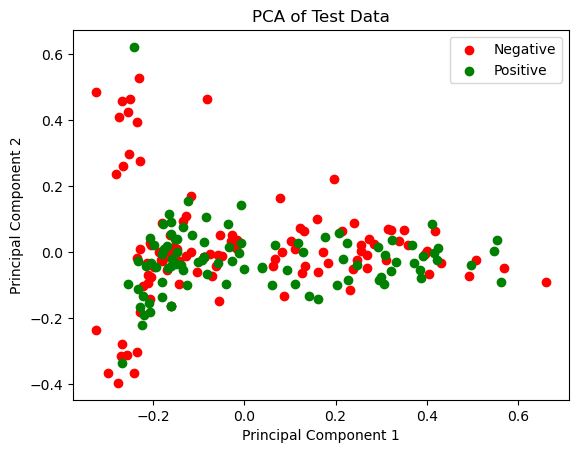

In [69]:
# Apply PCA to the test dataset [ / 2 marks]
pca = PCA(n_components=2)
pca.fit(TfIDF_train)
TfIDF_train_pca = pca.transform(TfIDF_train)
TfIDF_test_pca = pca.transform(TfIDF_test)

# Scatter plot of the cases for test data
plt.scatter(TfIDF_test_pca[y_test == 0, 0], TfIDF_test_pca[y_test == 0, 1], label='Negative', color='red')
plt.scatter(TfIDF_test_pca[y_test == 1, 0], TfIDF_test_pca[y_test == 1, 1], label='Positive', color='green')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Test Data')
plt.legend()
plt.show()

**Written Question:** What can we say about where the positive and negative cases lie in our plot? Could we use these concepts to discriminate positive and negative cases? If yes, why? If no, why not? Discuss your findings. [ /2 marks]

**Your answer:**
The positive and negative cases overlap a lot in our plot. Almost every positive case overlaps closely with negative cases, and there are some negative cases in the top-left of the plot that are distinct and away from the remainder of the plot. The plot follows this "upper-right curve shape" for both positive and negative test cases, similar to that of a square-root plot.

### Question  1.5 [ / 13 marks]

Repeat the process above, only now using a UMAP projection with two components. Test all combinations of ```n_neighbors=[2, 10, 25]``` and ```min_dist=[0.1, 0.25, 0.5]``` over the train data and choose the projection that you think is best, and apply it over the test data. Use 1000 epochs, a cosine metric and random initialization. If you have more than 8GB of RAM (as in Colab), you may want to set ```low_memory=False``` to speed up computations.

*Hint: [This link](https://stackoverflow.com/questions/16384109/iterate-over-all-combinations-of-values-in-multiple-lists-in-python) may be helpful.*



Best parameters: (2, 0.5)


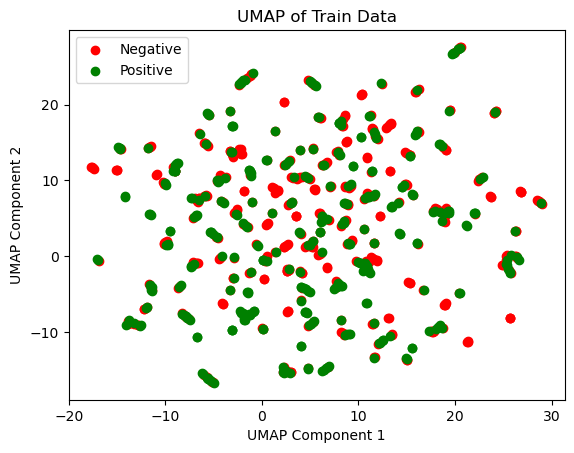

In [70]:
# Set parameters [ / 4 marks]
n_neighbors = [2, 10, 25]
min_dist = [0.1, 0.25, 0.5]
combined = [(n, d) for n, d in product(n_neighbors, min_dist)]

# UMAP projection with two components over the train data for each combination to find the best projection. 1000 epochs, cosine metric, and random initialization
results = []
for n, d in combined:
    umap = UMAP(n_components=2, n_neighbors=n, min_dist=d, n_epochs=1000, metric='cosine', random_state=seed, n_jobs=1)
    TfIDF_train_umap = umap.fit_transform(TfIDF_train)
    results.append((n, d, TfIDF_train_umap))

# Selecting the best parameters
best_projection = None
best_auc = 0
best_params = None
for n, d, projection in results:
    lr = LogisticRegressionCV(cv=5, random_state=seed, max_iter=1000)
    lr.fit(projection, y_train)
    auc = roc_auc_score(y_train, lr.predict_proba(projection)[:, 1])
    if auc > best_auc:
        best_auc = auc
        best_projection = projection
        best_params = (n, d)

print(f'Best parameters: {best_params}')

# Create plot [ [ /2 marks]]
plt.scatter(best_projection[y_train == 0, 0], best_projection[y_train == 0, 1], label='Negative', color='red')
plt.scatter(best_projection[y_train == 1, 0], best_projection[y_train == 1, 1], label='Positive', color='green')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP of Train Data')
plt.legend()

**Written Question:** Which paramter would you choose? [ / 2 makrs]

**Your Answer:**

n_neighbors = 10 and min_dist = 0.5.

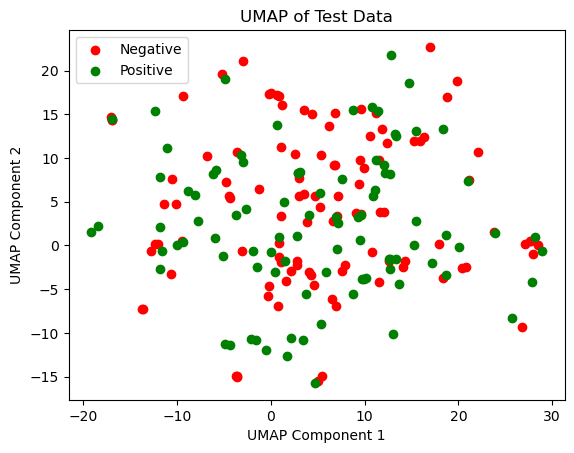

In [71]:
# Choose the paramters that you think are best and apply to test set [ / 2 marks]
n, d = best_params
umap = UMAP(n_components=2, n_neighbors=n, min_dist=d, n_epochs=1000, metric='cosine', random_state=seed, n_jobs=1)
TfIDF_train_umap = umap.fit_transform(TfIDF_train)
TfIDF_test_umap = umap.transform(TfIDF_test)

# Create plot [ /1 marks]
plt.scatter(TfIDF_test_umap[y_test == 0, 0], TfIDF_test_umap[y_test == 0, 1], label='Negative', color='red')
plt.scatter(TfIDF_test_umap[y_test == 1, 0], TfIDF_test_umap[y_test == 1, 1], label='Positive', color='green')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP of Test Data')
plt.legend()

**Written Question:** How does the plot compare to the PCA one? [ /2 marks]

**Your answer:**

The data is a lot more scattered than the PCA data was, with the PCA data showing a trend that was distinct, despite overlapping significantly between positive and negative cases.

---
## Task 2: Benchmarking predictive capabilities of the compressed data [ /24 marks]

For this task, we will benchmark the predictive capabilities of the compressed data against the original one. 



### Question 2.1 [ /6 marks]
Train a regularized logistic regression over the original TfIDF train set (with no compression) using l2 regularization. Calculate the AUC score and plot the ROC curve for the original test set. Use the training/test split created in Q1.1.

AUC score for training set: 0.850
AUC score for test set: 0.784


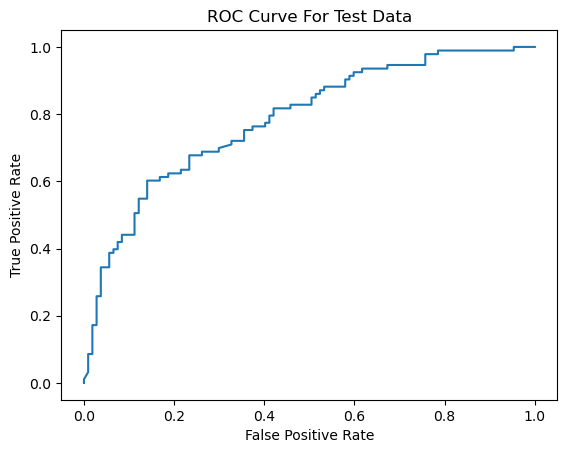

In [72]:
# Train and test using model LogisticRegressionCV over original train set with no compression and l2 regularization [ /4 marks]
lr = LogisticRegressionCV(cv=5, random_state=seed, max_iter=1000)
lr.fit(TfIDF_train, y_train)
auc_train = roc_auc_score(y_train, lr.predict_proba(TfIDF_train)[:, 1])
auc_test = roc_auc_score(y_test, lr.predict_proba(TfIDF_test)[:, 1])
print(f'AUC score for training set: {auc_train:.3f}')
print(f'AUC score for test set: {auc_test:.3f}')

# Plot ROC curve and compute AUC score [ /2 marks]
fpr, tpr, _ = roc_curve(y_test, lr.predict_proba(TfIDF_test)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For Test Data')
plt.show()

### Question 2.2 [ /8 marks]
Train a regularized logistic regression over an SVD-reduced dataset (with 10 components) using l2 regularization. Calculate the AUC score and plot the ROC curve for the SVD-transformed test set.

AUC score for training set: 0.768
AUC score for test set: 0.756


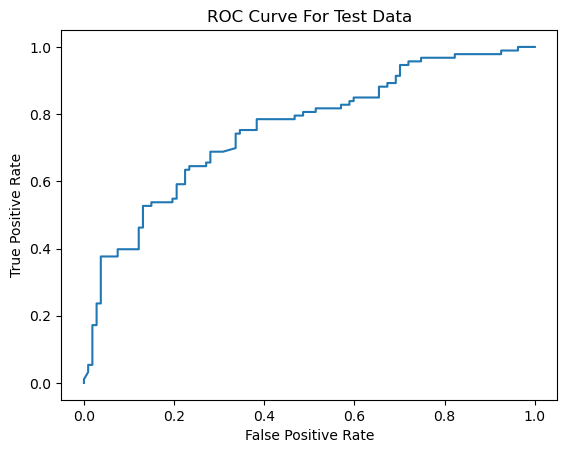

In [73]:
# Apply SVD first [ / 3 marks]
svd = TruncatedSVD(n_components=10)
TfIDF_train_svd = svd.fit_transform(TfIDF_train)
TfIDF_test_svd = svd.transform(TfIDF_test)

# Train and test using model LogisticRegressionCV [ /3 marks]
lr = LogisticRegressionCV(cv=5, random_state=seed, max_iter=1000)
lr.fit(TfIDF_train_svd, y_train)

# Plot ROC curve and compute AUC score [ /2 marks]
# Calculate the ROC curve points
auc_train = roc_auc_score(y_train, lr.predict_proba(TfIDF_train_svd)[:, 1])
auc_test = roc_auc_score(y_test, lr.predict_proba(TfIDF_test_svd)[:, 1])

# Save the AUC in a variable to display it. Round it first
print(f'AUC score for training set: {auc_train:.3f}')
print(f'AUC score for test set: {auc_test:.3f}')

# Create and show the plot
fpr, tpr, _ = roc_curve(y_test, lr.predict_proba(TfIDF_test_svd)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For Test Data')
plt.show()

### Question 2.3 [ /8 marks]
Train a regularized logistic regression over the UMAP-reduced dataset (with 10 components using the same parameters as Task 1.5) using l2 regularization. Calculate the AUC score and plot the ROC curve for the UMAP-transformed test set.

AUC score for training set: 0.699
AUC score for test set: 0.734


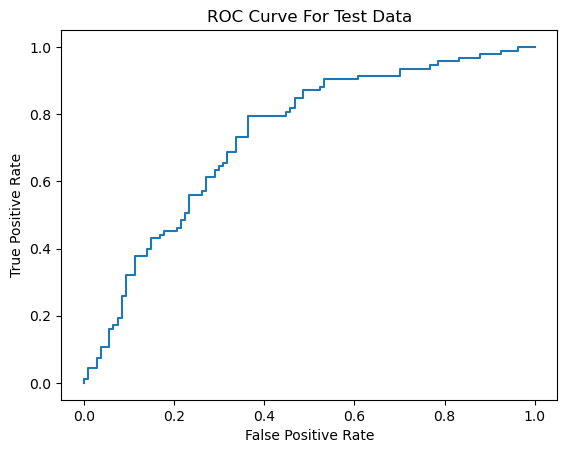

In [74]:
# Apply UMAP first [ / 3 marks]
umap = UMAP(n_components=10, n_neighbors=10, min_dist=0.5, n_epochs=1000, metric='cosine', random_state=seed, n_jobs=1)
TfIDF_train_umap = umap.fit_transform(TfIDF_train)
TfIDF_test_umap = umap.transform(TfIDF_test)

#Train and test using model LogisticRegressionCV [ /3 marks]
lr = LogisticRegressionCV(cv=5, random_state=seed, max_iter=1000)
lr.fit(TfIDF_train_umap, y_train)

# Plot ROC curve and compute AUC score [ /2 marks]
# Calculate the ROC curve points
auc_train = roc_auc_score(y_train, lr.predict_proba(TfIDF_train_umap)[:, 1])
auc_test = roc_auc_score(y_test, lr.predict_proba(TfIDF_test_umap)[:, 1])

# Save the AUC in a variable to display it. Round it first
print(f'AUC score for training set: {auc_train:.3f}')
print(f'AUC score for test set: {auc_test:.3f}')

# Create and show the plot
fpr, tpr, _ = roc_curve(y_test, lr.predict_proba(TfIDF_test_umap)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For Test Data')
plt.show()

### Question 2.4 [ /2 marks]
**Written Question:** Compare the performance of the three models. Which one is the best. [ / 2 marks] 

**Your Answer:**

The regular LogisticRegresion model in 2.1 performs the best on the test data. The AUC score is 0.784 compared to 0.767 and 0.734 for 2 and 3, respectively.

---
## Task 3: PCA + Hockey [ / 26 marks]
Connor Andrew McDavid is a Canadian professional ice hockey player and captain of the Edmonton Oilers of the National Hockey League (NHL). The data file `Hockey_sample.csv` provides a reduced version of Connor's game by game career data. Each row represents the stats of one game. The dataset has the following attributes:

|#| Attribute | Description |
| --- | --- | --- |
|0|`opposingTeam`|The team the player played against.|
|1|`home_or_away`|Whether a game was played home or away.|
|2|`icetime`|Log10 of total time the player played in seconds.|
|3|`gameScore`|Game score rating.|
|4|`I_F_primaryAssists`|Primary Assists the player has received on teammates' goals.|
|5|`I_F_secondaryAssists`|Secondary Assists the player has received on teammates' goals.|
|6|`log10_I_F_shotAttempts`|Log10 of shot attempts. Includes player's shots on goal, missed shots, and blocked shot attempts.|
|7|`I_F_goals`|Number of goals the player scored.|
|8|`I_F_rebounds`|Rebound shot attempts. These must occur within 3 seconds of a previous shot.|
|9|`I_F_reboundGoals`|Goals from rebound shot attempts.|
|10|`I_F_freeze`|Puck freezes after a player's shot. The  number of puck freezes by goalies after the player's unblocked shot attempts.|
|11|`I_F_playContinuedInZone`|Number of times the play continues in the offensive zone after the player's shot besides an immediate rebound shot.|
|12|`I_F_playContinuedOutsideZone`|Number of times the play goes outside the offensive zone after the player's shot.|
|13|`I_F_savedShotsOnGoal`|Number of the player's unblocked shots that were saved by the goalie.|
|14|`I_F_savedUnblockedShotAttempts`|Number of the player's unblocked shots that were saved by the goalie or missed the net.|
|15|`I_F_penalityMinutes`|Number of penalty minutes the player has received.|
|16|`log10_I_F_faceOffsWon`|Log10 of number of faceoffs the player has won.|
|17|`I_F_hits`|Number of hits the player has given.|
|18|`I_F_takeaways`|Number of takeaways the player has taken from opponents.|
|19|`I_F_giveaways`|Number of giveaways the player has given to other team.|
|20|`I_F_lowDangerGoals`|Goals from low danger shots.|
|21|`I_F_mediumDangerGoals`|Goals from medium danger shots.|
|22|`I_F_highDangerGoals`|Goals from high danger shots.|
|23|`I_F_unblockedShotAttempts`|All shot attempts that weren't blocked.|
|24|`I_F_dZoneGiveaways`|Giveaways in the team's defensive zone.|
|25|`penalityMinutesDrawn`|Number of penalty minutes the player has drawn.|
|26|`penaltiesDrawn`|Number of penalties the player has drawn.|

### Question 3.1 [ / 6 marks]

Drop categorical attributes, standardize numerical ones, and finally, with "icetime" as your target create the matrix of predictors and target vector, calling them `X1` and `y`, respectively. What is the `shape` of `X1` and `y`?

Hint they should be as the following:

Shape of X1: (2725, 24)

Shape of y: (2725,)

In [75]:
# Read data
df = pd.read_csv('Hockey_sample.csv')

# Get categorical attributes
categorical_attributes = df.select_dtypes(include=['object']).columns

# Drop categorical attributes
df = df.drop(categorical_attributes, axis=1)

# Standardize numerical attributes
df = (df - df.mean()) / df.std()

# Create matrix of predictors and target vector with "icetime" as target, calling them X1 and y
X1 = df.drop('icetime', axis=1)
y = df['icetime']


print(f'Shape of X1: {X1.shape}')
print(f'Shape of y: {y.shape}')

Shape of X1: (2725, 24)
Shape of y: (2725,)


### Question 3.2 [ / 10 marks]

Use a 15-component regular PCA to transform `X1` and create the scree plot. Let $p$ be the **minimum** number of PCs required in order to capture at least 80% of total variance. What would be the value of $p$? Reduce the dimension of `X1` to $p$ and call this new array `X2` (retain `X1` intact though, we need it for later).

In [76]:
# 15-component regular PCA to transform X1 and create scree plot
pca = PCA(n_components=X1.shape[1])
pca.fit(X1)
explained_variance = pca.explained_variance_ratio_.cumsum()

# min # of PCs to capture >=80% of total variance
p = np.argmax(explained_variance > 0.8)

# Print out p
print(f'Number of components required to explain 80% of the variance: {p}')

# Reducing dimension of X1 to p and calling it X2
pca = PCA(n_components=p)
X2 = pca.fit_transform(X1)

Number of components required to explain 80% of the variance: 10


### Question 3.3 [ / 10 marks]

Now that you have 2 different design matrices (*i.e.*, `X1` and `X2`) let's try two different scenarios: Train a simple linear regression (with default arguments) once using `X1`, and another time using the combination of `X1` and `X2` (*i.e.* concatenate them). Use cross-validation with RMSE as the error measure to identify the best model among the two. Report the cross-validation RMSE along with thier CIs for both models.

(For the cross-validation, do five-fold shuffled. For train/test split, use sklearn's default value for test set size.)

In [77]:
# Create linear regression model and train it on X1
lr = LinearRegression()
lr.fit(X1, y)

# Calculate RMSE using cross-validation with 5 folds
rmse = np.sqrt(-cross_val_score(lr, X1, y, cv=5, scoring='neg_mean_squared_error').mean())

# Calculate the standard deviation of the RMSE
std = np.std(cross_val_score(lr, X1, y, cv=5, scoring='neg_mean_squared_error'))

# Calculate the t-value for 95% confidence interval
t_value = t.ppf(0.975, 4)

# Calculate the confidence interval
ci = [rmse - t_value * std, rmse + t_value * std]

# Print the RMSE and confidence interval
print(f'RMSE and 95% confidence interval: {rmse:.3f} +/- {ci[1] - rmse:.3f}')

# Simple linear regression using X1X2 concatenated, getting the cross-validation with 5 folds and RMSE
# Concatenate X1 and X2
X1X2 = np.concatenate([X1, X2], axis=1)

# Create linear regression model and train it on X1X2
lr = LinearRegression()
lr.fit(X1X2, y)

# Calculate RMSE using cross-validation with 5 folds
rmse = np.sqrt(-cross_val_score(lr, X1X2, y, cv=5, scoring='neg_mean_squared_error').mean())

# Calculate the standard deviation of the RMSE
std = np.std(cross_val_score(lr, X1X2, y, cv=5, scoring='neg_mean_squared_error'))

# Calculate the t-value for 95% confidence interval
t_value = t.ppf(0.975, 4)

# Calculate the confidence interval
ci = [rmse - t_value * std, rmse + t_value * std]

# Print the RMSE and confidence interval
print(f'RMSE and 95% confidence interval: {rmse:.3f} +/- {ci[1] - rmse:.3f}')

RMSE and 95% confidence interval: 0.589 +/- 0.113


RMSE and 95% confidence interval: 0.590 +/- 0.118


---
$$The End$$